# Classify American Sign Language Alphabet

In this notebook we will learn how to classify american sign language alphabet using Pytorch and deep learning networks, We will use a pre-trained model from PyTorch models zoo and we will retrain the last parts of the network on our problem.
We will use the python and GPU environment in Watson studio for faster training, Without having to go anywhere else we will be able to download, explore, built, and train our model.


<img src="https://raw.githubusercontent.com/IBM/ASL-Pytorch/master/images/asl.jpg" alt="asl" width="80%%" height="80%"/>



In this notebook, we will use PyTorch to build and train a deep learning model to classify images to 29 classes (26 ASL alphabet, space, Del, and nothing) which can be used later to help Deaf peope communicate with other and maybe with computers as well. We will use a pre-trained mobile network and we will define our classifier and connect it to network, then train this classifier along with some of the last blocks of the network on our dataset.

In this notebook we will:

1- Obtain dataset from Kaggle.  
2- explore data and define transformers to preprocess images before training.  
3- define our classifier to have an output layer of 29 outputs.  
4- train the last blocks of the network along with the classifier we defined.  
5- test the model we trained.  

This notebook uses python 3.6 + GPU environment which allow us to do the whole process and train complex model in the same place which is a notebook in Watson studio.
Learn more about available environments <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/gpu-environments.html"> Watson Studio environments.</a>




# Learning Goals

In this notebook, you will learn how to:

* Download and prepare data in Watson studio.  
* Download and retrain pre-trained PyTorch models on your problem.  
* Train and test your model.

# Contents  
1- [Setting up the environment and fetching the dataset](#1.-Setting-Up-The-Environment).  
2- [Explore dataset folders and show random sample](#2.-Explore-Data).  
3- [preprocess images by transforms and load them to dataloaders](#3.-Process-and-load-images).  
4- [Choose a pre-trained model and retrain](#4.-Customize-our-network).  
5- [Try the model before any training](#5.-Try-the-model-before-any-training).   
6- [Configure training parameters and start the training](#6.-Configure-training-parameters-and-start-the-training).  
7- [Test your trained model on random image](#7.-Test-The-Model-After-Training).    
8- [Summary and Resources](#8.-Summary-and-Resources).  

# 1. Setting Up The Environment And Fetching Data 

## 1.1. Set up the notebook   
#### if you are already in the notebook with GPU environment please ignore this part

We will use Watson studio to run this notebook, Watson studio is available through IBM cloud or IBM Cloud Paks For Data.

* To start you must have IBM cloud account, Get your for free <a href="https://cloud.ibm.com/registration">Here.</a>   
* From the catalog create a <a href="https://cloud.ibm.com/catalog/services/watson-studio">watson studio</a> with standard plan or more and make sure the region is dallas to enable GPU environment.  
* create a watson studio project <a href="https://www.youtube.com/watch?v=-CUi8GezG1I">see tutorial here.</a>  
* create a new notebook from watson studio with GPU support.    
    * the notebook should have a GPU support <a href="https://www.youtube.com/watch?v=RNIWtpnNBoo">click here to learn how to create a notebook with GPU support.</a>
    * Use the From URL option and use this URL: https://github.com/mostafa3m/Pytorch-ASL/blob/master/ASL_v2.ipynb

## 1.2. Fetching data 

In this section, we will get the required missing packages, download, and unzip the dataset.

### Get Kaggle CLI and torch vision package

First, we will need to install Kaggle CLI and torch vision package, For that, we use the exclamation mark to run command in the kernel.

In [1]:
#install torchvision and kaggle
!pip install torchvision
!pip install kaggle

### Download and unzip the dataset 

We will use a dataset of 87.0k ASL Alphabet images (JPG) and 29 categories (26 ASL alphabet, space, Del, and nothing) offered by amarinderplasma on Kaggle. For more about the dataset <a href="https://www.kaggle.com/amarinderplasma/alphabets-sign-language"> ASL Images.</a>

* In this cell you should import your Kaggle account credentials to be able to download the data through Kaggle CLI. To get your credentials <a href="https://www.kaggle.com/docs/api">Kaggle API key.</a>
* Please note the line should be run as it is as one line to make sure all commands are started in the same kernel.

In [2]:
# download dataset and extract it
! export KAGGLE_USERNAME="Your Kaggle Username" && export KAGGLE_KEY="Your Kaggle API Key" && kaggle datasets download --unzip amarinderplasma/alphabets-sign-language
! ls

alphabets-sign-language.zip: Skipping, found more recently modified local copy (use --force to force download)
alphabets-sign-language.zip  asl_alphabet_test	 asl_alphabet_valid
asl_alphabet_1		     asl_alphabet_train


# 2. Explore Data

Here we will explore sub-folders and files of our data and show some samples of it.

In [3]:
! pwd && ls
print("\nFolders(classess) in training folder: ...")
! cd asl_alphabet_train && ls

/home/dsxuser/work
alphabets-sign-language.zip  asl_alphabet_test	 asl_alphabet_valid
asl_alphabet_1		     asl_alphabet_train

Folders(classess) in training folder: ...
A  C  del  F  H  J  L  N	O  Q  S      T	V  X  Z
B  D  E    G  I  K  M  nothing	P  R  space  U	W  Y


As we see the dataset is separated into Train, Test, and validate folders, Each has 29 folders for our classes.
In this notebook, we will only use  train folder for training and valid folder to validate.  
Now let us load our dataset to data loaders using datasets in torch vision and show some of those images.
* Let us start by importing needed libs

In [4]:
#import  needed libraries and check the used gpu
import torch
from torch import nn,optim
from torchvision import transforms, models ,datasets
import numpy as np
import matplotlib.pyplot as plt
import glob
from mpl_toolkits.axes_grid1 import ImageGrid


* Let us show some sample images

Test folder has 29 images for each of our classes so we can show images in the test folder to see some sample of the data.


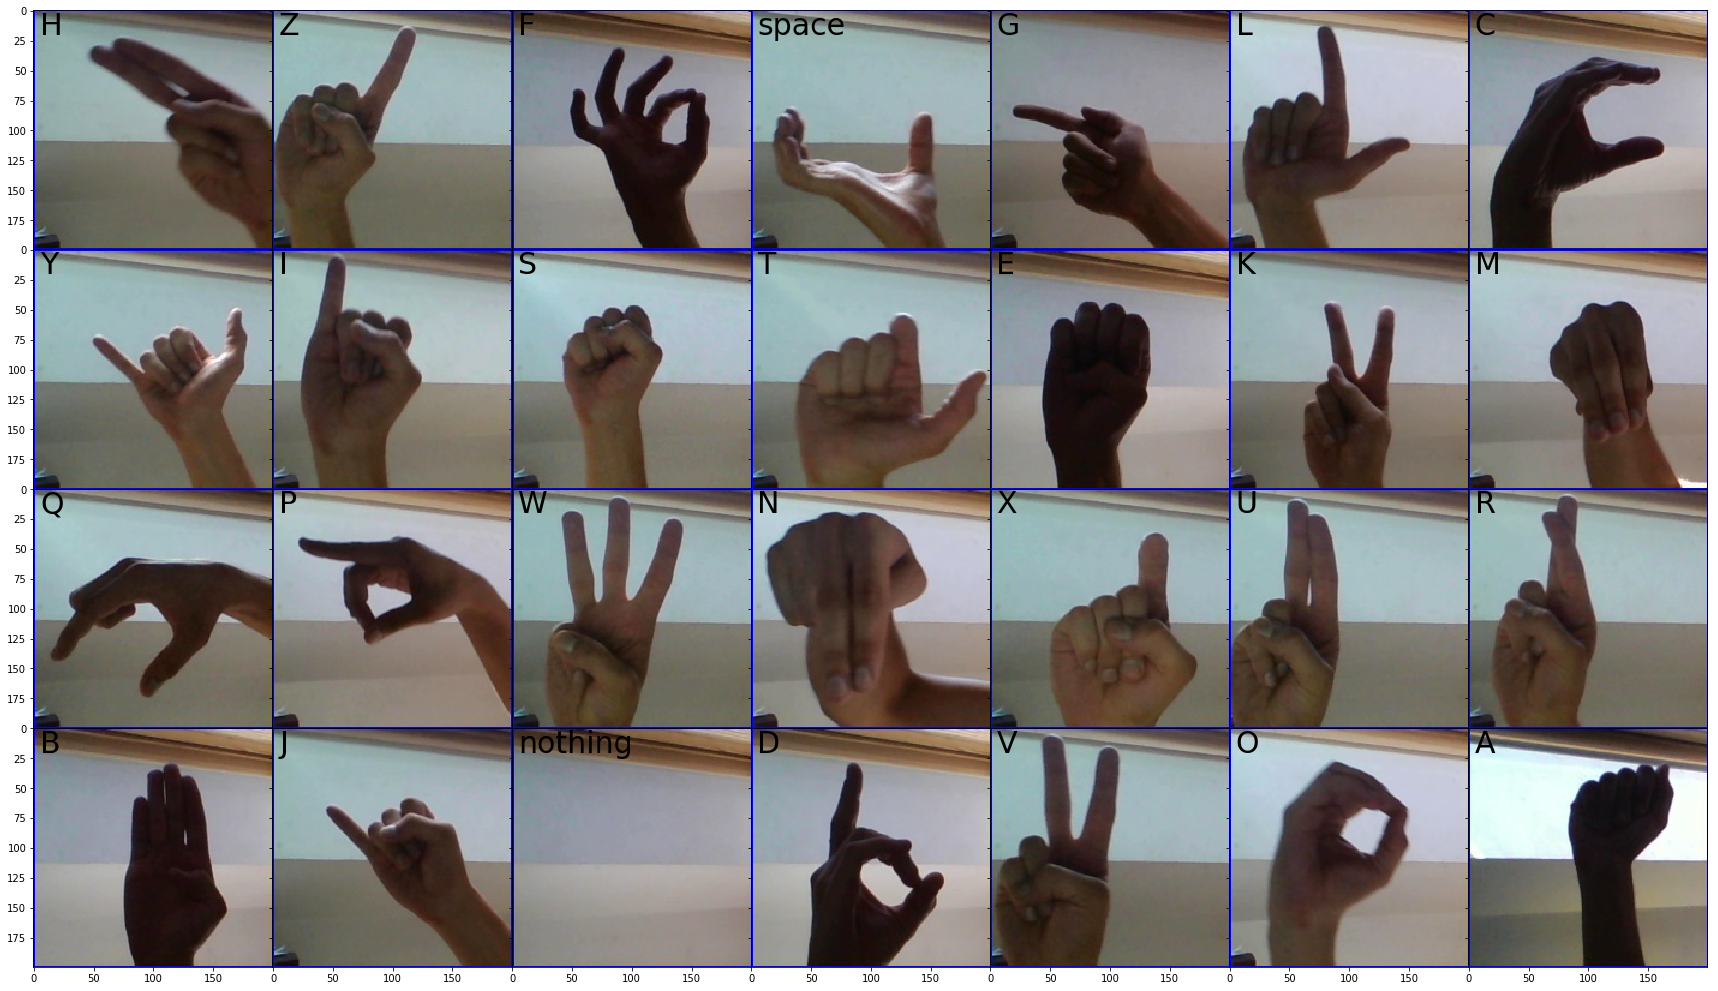

In [5]:
%matplotlib inline

ASL=np.array(glob.glob('asl_alphabet_test/*')) 

fig = plt.figure(figsize=(30, 30))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(4, 7),  
                 axes_pad=0,  # pad between axes in inch.
                 )
l=0
for img in ASL:
        im=plt.imread(img)
        grid[l].imshow(im,cmap='gray',interpolation='nearest')
        grid[l].text(5,20, img.split('/')[1].split('_')[0] ,fontsize=30)
        l+=1


# 3. Process and load images

## 3.1. define transformers  
we now pre-process our images and add some augmentation by rotating images by 30 degrees and flip some of them horizontally.  
All Pytorch pre-trained models expect input images normalized in the same way so we will normalize our images too, learn more <a href="https://pytorch.org/docs/stable/torchvision/models.html">Pytorch docs.</a>

In [6]:
#creating the dataloaders 

# Define transforms for the training data and testing data
train_path='asl_alphabet_train'
valid_path='asl_alphabet_valid'

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(p=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

## 3.2. load images to data loaders

Now it is time to create data loaders to feed our model with data during the training phase.  
We will use <a href="https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder">ImageFolder</a> from torchvision to load our data.    
We also print the used processor to make sure we are using the GPU for faster training, In our case, it is Tesla k80.  
We will also print "class_to_idx" to show how our classess are mapped to different integers or indices.

In [7]:
# load data to loaders
train_data = datasets.ImageFolder(train_path, transform=train_transforms)
test_data = datasets.ImageFolder(valid_path, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=512)

#print used Device
print(f"Device used: cpu")

#print class to index mapping
print(f"class to index mapping: {train_data.class_to_idx}")


Device used: cpu
class to index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


# 4. Customize our network

## 4.1. Choose a Pretrained model
choose a pre-trained model you think would have good accuracy for the problem and freeze all layers to make sure not all the network is trained during the training process.   
A list of Pytorch model zoo can be found <a href="https://pytorch.org/docs/stable/torchvision/models.html">here.</a>  
We will also print the model classifier to check the number of input neurons to consider when creating our classifier.

In [8]:
# choose a pretrained model to start with check options here: https://pytorch.org/docs/stable/torchvision/models.html
model = models.mobilenet_v2(pretrained=True)

# Freeze parameters of the tarined network 
for param in model.parameters():
    param.requires_grad = False
    
#print the model to check the classifer and change it
print (model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)


## 4.2. Choose which layers to train
In the next cell, we will unfreeze some of the last blocks of our network and we will define our custom classifier to have 29 outputs then we will attach it to the model.  
We will also choose the optimizer we want and define the learning rate for it.

In [9]:
# define new classifier and append it to network but remember to have a 29-neuron output layer for our two classes.
model.classifier= nn.Sequential(nn.Dropout(p=0.6, inplace=False),
                                nn.Linear(in_features=1280, out_features=29, bias=True),
                                nn.LogSoftmax(dim=1))

# unlock last three blocks before the classifier(last layer).
for p in model.features[-3:].parameters():
    p.requires_grad = True  

    
# choose your loss function
criterion = nn.NLLLoss()

# define optimizer to train only the classifier and the previous three block.
optimizer = optim.Adam([{'params':model.features[-1].parameters()},
                        {'params':model.features[-2].parameters()},
                        {'params':model.features[-3].parameters()},
                        {'params':model.classifier.parameters()}], lr=0.0005)

# define Learning Rate scheduler to decrease the learning rate by multiplying it by 0.1 after each epoch on the data.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

#print the classifier now
print(model.classifier)

#print the whole model
# print(model)


Sequential(
  (0): Dropout(p=0.6, inplace=False)
  (1): Linear(in_features=1280, out_features=29, bias=True)
  (2): LogSoftmax(dim=1)
)


# 5. Try the model before any training

you can run the cell multiple times and check if the prediction is true or not?!

image number 102
---------------------
label: Q
prediction: B


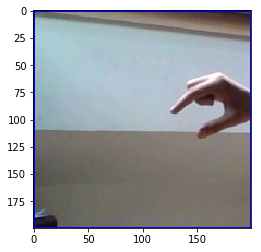

In [10]:
### try your model on some images
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data_t = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader_t = torch.utils.data.DataLoader(test_data_t, batch_size=200,shuffle=True)
images_t , labels_t=next( iter(testloader_t) )

#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images_t[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0)

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels_t[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])



# 6. Configure training parameters and start the training  
## 6.1. choose the number of epochs and printing intervals and move the model to the GPU.

In [11]:
#Define number of epochs through data and run the training loop
import math
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 2
step = 0
running_loss = 0
print_every = 5
trainlossarr=[]
testlossarr=[]
oldacc=0

steps=math.ceil(len(train_data)/(trainloader.batch_size))

## 6.2. Start the training loop
Set back and watch your model learn.

In [ ]:
%%time

for epoch in range(epochs):
    print(f"--------------------------------- START OF EPOCH [ {epoch+1} ] >>> LR =  {optimizer.param_groups[-1]['lr']} ---------------------------------\n")
    for inputs, labels in trainloader:
        model.train()
        step += 1
        inputs=inputs.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        props = model.forward(inputs)
        loss = criterion(props, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (step % print_every == 0) or (step==steps):
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    props = model.forward(inputs)
                    batch_loss = criterion(props, labels)

                    test_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(props)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
 
                    
                        

            print(f"Epoch ({epoch+1} of {epochs}) ... "
                  f"Step  ({step:3d} of {steps}) ... "
                  f"Train loss: {running_loss/print_every:.3f} ... "
                  f"Test loss: {test_loss/len(testloader):.3f} ... "
                  f"Test accuracy: {accuracy/len(testloader):.3f} ")
            trainlossarr.append(running_loss/print_every)
            testlossarr.append(test_loss/len(testloader))
            running_loss = 0
            
        
    scheduler.step()
    step=0


--------------------------------- START OF EPOCH [ 1 ] >>> LR =  0.0005 ---------------------------------

Epoch (1 of 2) ... Step  (  5 of 142) ... Train loss: 3.206 ... Test loss: 2.686 ... Test accuracy: 0.426 
Epoch (1 of 2) ... Step  ( 10 of 142) ... Train loss: 2.427 ... Test loss: 1.712 ... Test accuracy: 0.645 
Epoch (1 of 2) ... Step  ( 15 of 142) ... Train loss: 1.713 ... Test loss: 1.134 ... Test accuracy: 0.745 
Epoch (1 of 2) ... Step  ( 20 of 142) ... Train loss: 1.259 ... Test loss: 0.848 ... Test accuracy: 0.846 
Epoch (1 of 2) ... Step  ( 25 of 142) ... Train loss: 0.935 ... Test loss: 0.672 ... Test accuracy: 0.887 
Epoch (1 of 2) ... Step  ( 30 of 142) ... Train loss: 0.727 ... Test loss: 0.552 ... Test accuracy: 0.909 
Epoch (1 of 2) ... Step  ( 35 of 142) ... Train loss: 0.581 ... Test loss: 0.496 ... Test accuracy: 0.910 
Epoch (1 of 2) ... Step  ( 40 of 142) ... Train loss: 0.488 ... Test loss: 0.440 ... Test accuracy: 0.928 
Epoch (1 of 2) ... Step  ( 45 of 142)

# 7. Test The Model After Training

In [13]:
### try your model on some images
%matplotlib inline

#turn model to evaluation mode
model.eval()

#load some of the test data 
test_data = datasets.ImageFolder(valid_path,transforms.Compose([transforms.ToTensor()]))
testloader = torch.utils.data.DataLoader(test_data, batch_size=200,shuffle=True)
images , labels=next( iter(testloader) )

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

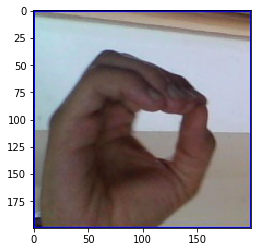

In [14]:
#Choose arandom image from 0 to 199
index = np.random.randint(0, 199)
test_img=images[index]

#show choosed image
t=transforms.ToPILImage()
plt.imshow(t(test_img))

#normalize image as in the training data
t_n=transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
test_img=t_n(test_img).unsqueeze(0)

#classify image using our model
res = torch.exp(model(test_img))

#invert class_to_idx keys to values and viceversa.
classes=train_data.class_to_idx
classes = {value:key for key, value in classes.items()}

print(f"image number {index}")
print("---------------------")

#print real class
print("label:",classes[labels[index].item()])

#print predicted class
print("prediction:", classes[res.argmax().item()])



# 8. Summary and Resources

You made it, Thanks for completing the notebook.  
* In this notebook we learned how to do the whole process of model building and training on notebook leveraging the power GPU environment to train deep learning models.
* Don't forget to get back and try different parameters or different models.

## Resources
* <a href="https://dataplatform.cloud.ibm.com/gallery">Other Great notebooks.</a>  
* <a href="https://www.python.org/">Official Python website.</a>  
* <a href="https://pytorch.org/">Official PyTorch website</a>  
* <a href="https://cloud.ibm.com/registration">Get started today on IBM Cloud for free!</a>   
* <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/gpu-environments.html">Learn more about GPU environments.</a>   

## Author

Mostafa Abdelaleem is a Developer Advocate at IBM who contributes to AI and data science community in order to democratize them.

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.